# Nettoyage des données

In [59]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from datetime import datetime
import seaborn as sns
from fuzzywuzzy import process
import re
import time
from auxiliary_functions import detect_duplicates

## 1. Chargement des données

In [60]:
engine = create_engine('sqlite:///Data/data.db', echo=False)
con = engine.connect()
df_patient_raw = pd.read_sql('select * from patient', con=con)
df_patient = df_patient_raw.copy()
df_pcr_raw = pd.read_sql('select * from test', con=con)
df_pcr = df_pcr_raw.copy()
con.close()

Chargement d'une source de données supplémentaire qui sera peut être utile la complétion des données. La base de données fait le lien entre code postal et état. La base associe ausi (de manière non unique) un code postale à des coordonnées géographiques.

In [61]:
## Australian Post code database,
## downloaded from https://github.com/Elkfox/Australian-Postcode-Data
australia_geo_data = pd.read_csv("Data/au_postcodes.csv")

# Cleaning, formatting, deduplicating
australia_geo_data.state_code = australia_geo_data.state_code.str.lower()
australia_geo_data.postcode = australia_geo_data.postcode.astype(str)

# Creating oa postcode_state table which might be used for data complation. 
postcode_state = australia_geo_data[['postcode', 'state_code']].copy()
postcode_state.drop_duplicates(inplace=True)
dup_code = postcode_state.loc[postcode_state.postcode.duplicated(), 'postcode']
postcode_state = postcode_state.loc[~postcode_state.postcode.isin(dup_code),]
postcode_state.columns = ['postcode', 'state_postcode_based']
postcode_state.postcode = postcode_state.postcode.apply(lambda x: "%04d" % int(x)) # format postcode with 4 digits
postcode_state.head()

,postcode,state_postcode_based
0,0200,act
1,0221,act
5,2600,act
17,2601,act
21,2602,act


## 2. Nettoyage de la table pcr

In [62]:
df_pcr.pcr.value_counts()

N           3482
Negative    3134
Positive    1283
P            901
Name: pcr, dtype: int64

In [63]:
# Formatting pcr results columns and drop duplicates
df_pcr.pcr.replace("N", "Negative", inplace=True)
df_pcr.pcr.replace("P", "Positive", inplace=True)
df_pcr.drop_duplicates(inplace=True) ## 21 duplicated

In [64]:
## Look for duplicates in the patient id, for those replace the PCR result
## by NA
duplicated_patient = df_pcr.patient_id.duplicated()
sum(duplicated_patient) ## 14 duplicated patient with inconsistent PCR results
df_pcr.loc[duplicated_patient, 'pcr'] = None
df_pcr.drop_duplicates(['patient_id'], inplace=True)
df_pcr.shape

(8765, 2)

## 3. Première visualisation et nettoyage de la table patients

In [65]:
df_patient.describe()

,patient_id,street_number,date_of_birth,age
count,20000.000000,19618.000000,1.798900e+04,16003.000000
mean,553918.938750,98.812468,1.949638e+07,27.534337
std,260234.961111,2481.908686,2.926916e+05,7.807008
min,100005.000000,0.000000,1.290041e+07,0.000000
25%,330194.250000,10.000000,1.924113e+07,24.000000
50%,556327.500000,24.000000,1.950032e+07,29.000000
75%,779419.500000,60.000000,1.975052e+07,33.000000
max,999993.000000,342951.000000,1.999123e+07,92.000000


### Variable *patient_id*

In [66]:
df_patient.patient_id.duplicated().sum()

202

In [67]:
dup_patient_id = df_patient.loc[df_patient.patient_id.duplicated(), 'patient_id'].unique()
dup = df_patient.loc[df_patient.patient_id.isin(dup_patient_id),].copy()
dup.sort_values(['patient_id'])

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
12117,109304,zachary,farronato,30.0,outtrim avenue,como,2196,vic,19090801.0,31.0,07 22894061,the reefs
14839,109304,bailey,donaldson,20.0,tardent street,ryde,0812,qld,19580310.0,26.0,07 13479210,None
4386,110207,toby,brock,4.0,merriman crescent,baralaba,3025,nsw,19000424.0,35.0,08 33842007,leitrim
12989,110207,zali,brock,32.0,hedger street,toorak,5038,act,NaN,22.0,08 96818512,None
10184,115791,hannah,clarke,70.0,galmarra street,mayfield,7010,vic,19830828.0,25.0,04 70760611,None
...,...,...,...,...,...,...,...,...,...,...,...,...
10507,990695,erin,braunack,49.0,moondarra street,broken hill,2640,qld,19830122.0,30.0,03 69523317,yuulong
8764,990936,amy,royle,90.0,whittell crescent,coramba,5032,sa,19950326.0,NaN,08 07309295,tewantin plaza
12563,990936,samantha,green,21.0,brierly street,ardrossan,2140,None,19380210.0,29.0,02 51600621,None
2385,994235,trent,stewart-jones,129.0,macfarland crescent,wangaratta,2732,nsw,NaN,NaN,07 98662458,mountview


Il y a des duplicats dans les id des patients sur des patients qui ne se ressemblent pas. On décide de les garder quand même. 

### Variables *Date_of_birth* et *age*

In [68]:
# Get date of birth to be in a proper date format
df_patient['clean_date_of_birth'] = df_patient['date_of_birth'].\
    apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d', errors='coerce'))
# Estimate the age of the patient base on the assumption that we are in march 2020
df_patient['estimated_age'] = datetime(2020, 3, 1) - df_patient.clean_date_of_birth
df_patient.estimated_age = df_patient.estimated_age.dt.days//365.25

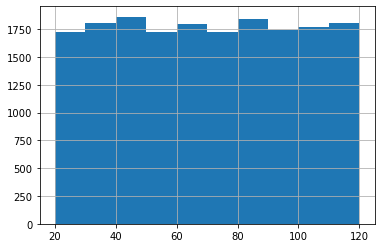

In [69]:
df_patient.estimated_age.hist()

On vérifie la cohérence entre la date de naissance et l'âge. 

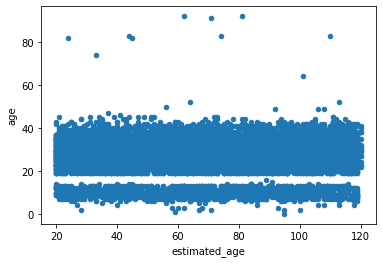

In [70]:
df_patient.plot.scatter(x="estimated_age", y="age")

Les deux données ne sont pas cohérentes. Par ailleurs, la distribution des ages estimés est étonnante (il y a peut être annonymisation de cette donnée qui n'est plus exploitable). On choisi de ne plus utiliser la variable date of birth et en particulier on ne l'utilisera pas pour imputer les ages manquants. 

### Variable *phonenumber*

On vérifie que les numéro de téléphone sont tous au bon format : 2 chiffres, un espace puis 8 chiffre. C'est bien le cas. 

In [71]:
#### Check phone numbers
def check_phone(phone_str):
    if phone_str is None:
        return True
    return bool(re.match("^0[0-9] [0-9]{8}$", phone_str))

df_patient['is_valid_phone_number'] = \
    df_patient.phone_number.apply(lambda x: check_phone(x))
df_patient.is_valid_phone_number = df_patient['is_valid_phone_number'].astype(bool)

not_valid_phone_number = df_patient.loc[~df_patient.is_valid_phone_number, ]
not_valid_phone_number

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,clean_date_of_birth,estimated_age,is_valid_phone_number


### Variable *postcode*

On vérifie que la variable postcode a le bon format (4 chiffre) et on corrige les éventuelles erreurs. 

In [72]:
# Check the format of the post code
unique_postcode_in_df = df_patient.postcode.value_counts(dropna=True)
is_valid_postcode = [bool(re.match("^[0-9]{4}$", x))
                      for x in unique_postcode_in_df.index]
unique_postcode_in_df = pd.DataFrame({'postcode': unique_postcode_in_df.index,
                                      'is_valid': is_valid_postcode,
                                      'count': unique_postcode_in_df.values})

wrong_postcode = unique_postcode_in_df.loc[~unique_postcode_in_df.is_valid,:]
wrong_postcode_rows = \
    df_patient.loc[df_patient.postcode.isin(wrong_postcode.postcode),:]
wrong_postcode_rows

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,clean_date_of_birth,estimated_age,is_valid_phone_number
3976,810644,juliana,grosvenor,5.0,connelly pace,3023,port noarlunga south,tas,19991215.0,NaN,03 55227740,None,1999-12-15,20.0,True
4080,986559,kirra,choi-lundberg,102.0,centaurus street,6168,naremburn,vic,19261104.0,27.0,08 69584599,None,1926-11-04,93.0,True
5792,752873,lochlan,blake,258.0,None,4216,toowoobma,wa,19080821.0,31.0,02 84630666,None,1908-08-21,111.0,True
6218,902348,isaac,nakoje,19.0,collier street,6017,brighton,None,19640421.0,8.0,02 69439226,None,1964-04-21,55.0,True
6618,678110,jaden,green,5.0,dovey place,3185,oraneg,vic,19151204.0,23.0,02 73534391,None,1915-12-04,104.0,True
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,None,None,NaT,NaN,True
9718,727290,tiffany,loukes,31.0,leal place,467l0,forest hill,nsw,19760706.0,23.0,None,pangani,1976-07-06,43.0,True
11333,738103,hugi,pascoe,167.0,leita court,3023,port lincoln,nsw,19040401.0,NaN,07 84786511,None,1904-04-01,115.0,True
14255,684359,sonia,green,50.0,kalgoorlie crescent,6112,ashfield,sa,NaN,9.0,03 46671647,None,NaT,NaN,True
15479,355033,abby,yoob,243.0,weston street,3181,forest hill,None,19660615.0,26.0,02 68667816,None,1966-06-15,53.0,True


In [73]:
##Looking at the rows with wrong formatted postcode, we see that the
## error is due to a swtich betwwen postcode and suburb columns.
## We correct that
tmp_postcode = df_patient.loc[wrong_postcode_rows.index, 'suburb']
df_patient.loc[wrong_postcode_rows.index, 'suburb'] = \
    df_patient.loc[wrong_postcode_rows.index, 'postcode']
df_patient.loc[wrong_postcode_rows.index, 'postcode'] = tmp_postcode

# There is still one invalid post code which cannot be match
df_patient.loc[9718, 'postcode'] = None

### Variable *sate*

In [74]:
df_patient.state.value_counts()

nsw    6143
vic    4352
qld    3516
wa     1580
sa     1391
       ... 
vc        1
qlg       1
ng        1
nsg       1
vkc       1
Name: state, Length: 102, dtype: int64

Il n'y a que 8 états an australie, il y a donc un problème de formattage de la données état. On va tenter de standardiser cette données en 
utiliser du fuzzy matching

In [75]:
valid_australia_states = ["nsw", "vic", "qld", "wa", "sa", "tas", "act", "nt"]
# Create a transcode table to associate each non formatted state string to a state
# in the list valid_australia_states. 
unique_states_in_df = df_patient.state.value_counts(dropna=True)
clean_states = [process.extractOne(x, valid_australia_states) \
                for x in unique_states_in_df.index]
state_transcode_table = pd.DataFrame(clean_states, columns=["clean_state", "state_match_score"])
state_transcode_table["state"] = unique_states_in_df.index
state_transcode_table.sort_values(by='state_match_score', inplace=True)
### When the match score is bellow 50, we consider the match to be too unsure
### to be taken seriously. Thus we will replace the state by a None.
unfit_match = state_transcode_table.state_match_score <= 50
state_transcode_table.loc[unfit_match, "clean_state"] = None
df_patient = df_patient.merge(state_transcode_table, how='left', on='state')
df_patient.clean_state.value_counts()

nsw    6205
vic    4378
qld    3543
wa     1584
sa     1395
tas     513
act     250
nt      132
Name: clean_state, dtype: int64

In [76]:
df_patient.clean_state.isna().sum()

2000

Il reste 2000 NA dans la colonne des états. On va essayer de compléter cette données à partir du code postale
et de la table postcode_state chargé au début. 

In [77]:
# Merge with postcode_state table
df_patient = df_patient.merge(postcode_state, how='left', on='postcode')
# check the onsistency between the clean_state variable of the state based on postcode
inconsistences = df_patient.loc[df_patient.clean_state != df_patient.state_postcode_based, 
                               ['postcode', 'state', 'clean_state', 'state_postcode_based', 'suburb']]
inconsistences

,postcode,state,clean_state,state_postcode_based,suburb
0,2527,wa,wa,nsw,ellenbrook
3,3620,wa,wa,vic,henty
4,4051,nsw,nsw,qld,campbell town
5,3556,qld,qld,vic,barmera
7,2170,qld,qld,nsw,maribyrnong
...,...,...,...,...,...
19994,2075,qld,qld,nsw,booragul
19996,3033,wa,wa,vic,hoppers crossing
19997,3616,tas,tas,vic,smithfield
19998,2443,wa,wa,nsw,beaumaris


On conclusion, il y a énormément d'incohérences entre l'état renseigné dans la base originelle et l'état estimé à partir 
du code postale. En regardant de près quelques cas (en allant voir exactement dans quel état ont les villes indiquées dans la colonne suburb), il semble qu'il faille plutôt donner raison à la variable state_postcode_based reconstituée à partir du postcode. Cependant, on ne le fera pas dans la suite préférant utiliser la donnée source. En tous les cas, on n'utilisera pas cette enrichissement pour imputer les données manquantes dans la variable clean_state. 

## 4. Suppréssion des doublons

Pour supprimer les doublons, on va regarder l'ensemble des variables suivantes : 
['given_name', 'surname', 'street_number', 'address_1', 'suburb', 'postcode', 'clean_state', 'date_of_birth', 'age', 'phone_number', 'address_2']
En particulier, on n'utilise pas le *patient_id* car on a vu plus haut que quand il était dupliqué cela ne correspondait à des lignes qui se ressemblent. Par ailleurs, on utilise la variable re-consitué *clean_state* et pas la variable *state* car on la considère comme plus juste.

On commence par une suppression des doublons exacts. Pour choisir entre deux doublons lequel garder, on va donner la priorité à celui qui est associé à un test pcr positif. 

In [78]:
dedupe_col_subset = ['given_name', 'surname', 'street_number', 'address_1',
                   'suburb', 'postcode', 'clean_state', 'date_of_birth', 'age',
                   'phone_number', 'address_2']

## Give priority to positive tests when there is a duplicate before dropping duplicates.
df_patient = df_patient.merge(df_pcr, on='patient_id', how='left')
df_patient.sort_values('pcr', inplace=True, ascending=False)
dedupe_df = df_patient.drop_duplicates(dedupe_col_subset, keep='first')

On sait qu'il reste néanmoins des doublons non exact. Voir ci-dessous par exemple

In [79]:
df_patient.loc[[12987, 11831, 10146, 13115], ]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,clean_date_of_birth,estimated_age,is_valid_phone_number,clean_state,state_match_score,state_postcode_based,pcr
12987,707871,emikly,green,5.0,jervois street,kuraby,3072,tas,19961029.0,23.0,03 10858290,None,1996-10-29,23.0,True,tas,100.0,vic,Positive
11831,250453,emiily,green,5.0,jervois street,kuraby,3072,tas,19961029.0,23.0,03 10868290,trewilga,1996-10-29,23.0,True,tas,100.0,vic,Negative
10146,506491,emiily,green,5.0,jervois street,kurqay,3072,tas,19961029.0,23.0,03 10868290,None,1996-10-29,23.0,True,tas,100.0,vic,NaN
13115,624186,emiily,green,5.0,jervoisbatreet,kuraby,3072,tas,19961029.0,23.0,03 10868290,trewizlga,1996-10-29,23.0,True,tas,100.0,vic,NaN


On va donc chercher à supprimer les doublons "similaires". Pour cela on va prendre chaque individu et le comparer à tous les autres en calculant une distance entre la chaine de character qui le représente et celle des autres individus. Pour calculer la distance entre deux chaines de character on peut utiliser par exemple les différentes fonctions du package fuzzyWuzzy (pour plus de détail, cf https://towardsdatascience.com/fuzzywuzzy-how-to-measure-string-distance-on-python-4e8852d7c18f).
Quand cette distance sera au dessus (ou en dessous selon la distance) d'un certains seuil, on pourra considérer que les deux chaines de charactères sont des doublons. 

L'algorithme proposé ici est un $O(n^2)$ où $n$ est le nombre d'individu dans notre dataframe *df_patient*. Il ne sera donc pas scalable et il faut faire attention à ce que le temps d'execussion d'une comparaison soit suffisement court.

Par ailleurs plus les strings à comparer sont grands plus chaque comparaison va être longue à faire. On ne peut donc pas se permettre de faire $n^2$ comparaison en utilisant comme base de comparaison l'ensemble de nos colonnes. On propose une approche où l'on va préselectionner un ensemble de bon candidats duplicats en comparants uniquement les colonnes "given_name" et "surname". On fera ensuite la comparaison en utilisant toutes les colonnes mais seulement sur le sous ensemble de candidats pré-sélectionné. 

Pour accélérer l'algorithme, on l'a aussi parallelisé en utilisant le package multiprocessing. Sur notre ordinatuer (8 coeurs i7), le calcul dure environ 20 minutes ce qui reste acceptable.

L'ensemble des fonctions auxilaires utilisées ainsi que les tests unitaires sont dans le scipt *auxiliary_functions.py*. 

Pour avoir un algorithme plus scalable, on aurait pu faire ce que suggère cet article : https://towardsdatascience.com/fuzzy-matching-at-scale-84f2bfd0c536. 

In [ ]:
run_dedupe = True
if run_dedupe:
    pre_dedupe_col_subset = ['given_name', 'surname']
    start = time.time()
    dedupe_df, dup_candidates = detect_duplicates(dedupe_df, pre_dedupe_col_subset,
                                                  dedupe_col_subset)
    stop = time.time()
    print("processing_time : ", (stop - start)/60, " minutes")
    # Save results
    dup_candidates.to_pickle("Data/dup_candidates.pkl")
    engine = create_engine('sqlite:///Data/data.db', echo=False)
    con = engine.connect()
    dedupe_df.to_sql("clean_data", engine.connect(), if_exists='replace')
    con.close()

else:
    dup_candidates = pd.read_pickle("Data/dup_candidates.pkl")
    con = engine.connect()
    dedupe_df = pd.read_sql('select * from clean_data', con=con)
    con.close()

In [ ]:
print(dedupe_df.shape)
print(df_patient.shape)
print(df_patient.shape[0] - dedupe_df.shape[0])
(df_patient.shape[0] - dedupe_df.shape[0])/df_patient.shape[0]

Au final, on a enlevé en tout 1324 duplicats sur un dataframe inital de 20000 patients. Cela représente ~7% des données. 